In [1]:
%load_ext autoreload
%autoreload 2

This Jupyter Notebook is a demonstration of an end to end data generation, model training, and confidence calibration. In the following cell, we comment on the most important parameters. For the remaining parameters, please refer to the documentation

In [2]:
import numpy as np
import ChromFormer
import sys
import torch
from torch_geometric.data import DataLoader
from ChromFormer.data_generation.Uniform_Cluster_Walk import synthetic_biological_uniform_data_generator, generate_biological_structure
from ChromFormer.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from ChromFormer.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from ChromFormer.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear, TransConf, train_trans_conf, evaluate_trans_conf
from ChromFormer.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from ChromFormer.Data_Tools.Data_Calculation import generate_hic, save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled
from ChromFormer.Model.lddt_tools import lddt, get_confidence_metrics
from ChromFormer.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import random
load_dotenv()
#The following uses the package python-dotenv that can be installed by pip to load the variable that contains your path to the data folder in a .env file 
DATA_DIR = os.environ.get('DATA_DIR')
## Folder to which the training and testing data will be saved.
DATA_PATH=f'{DATA_DIR}/demo/'
TRAIN_DATASET_SIZE = NB_TRAINING = 200 # training dataset size
TEST_DATASET_SIZE = NB_testing = 100 # testing dataset size
NB_BINS = 202 # number of points per structure

# Data Generation relevant parameters
DELTA = 0.45 # Smoothness parameter
ST_SIG = 5 
END_SIG = 7
SIG = 4 # structure compactness
CLUST_SIG = 1.5 # TADs compactness
CLUST_PROB = 0.1 # Probability of entering a TAD
SECONDSTEP = False
SEED = 42
EXPONENT = 1 # root power value for the inverse function (Distance -> Hi-C)
ICING = True # Whether to use ICE normalisation with Z_score or not
MINMAXUSE= False # Whether MinMax needs to be used before optimal transport on the synthetic data or not
TRANSPORTATION = True # Whether to use optimal transport or not
SOFTMAXING = False # Whether to use a synthetic to true HiC softmax function or not. Not needed if already using optimal transport

# Model relevant parameters
NB_HEAD = 2 # Number of head per Transformer Encoder
NB_HIDDEN = 100  # The first feedforward dimension and the Encoding dimension used to project the data before making it go through the transformer
NB_LAYERS = 1 # Number of transformer layers
DROPOUT = 0.1 # Dropout rate
SECD_HID = 48 # Second feedforward dimension of the transformer encoder 
ZERO_INIT = False # Whether to use Zero Initialisation or Xavier initialisation for confidence logits linear layer weights
NUM_BINS_LOGITS = 100 # Number of confidence logit classes
NB_EPOCHS = 40
BATCH_SIZE = 10
ANGLE_PRED = EMBEDDING_SIZE = 3 # Simple 3D structure embedding dimension
LAMBDA_BIO = 0.1 # Biological loss weight
LAMBDA_KABSCH = 0.1 # Kabsch loss weight
LAMBDA_LDDT = 0.1 # LDDT confidence loss weight




## Data Generation

The next part shows how to create a single structure. This structure is then plotted. This is done to find the desired parameters and to see how a structure with these parameters would look like. Important parameters are the following: nb_nodes representing the number of points in the structure, delta representing how smooth the structure should be, sigma representing how compact the overall structure should be, cluster_sigma representing how compact TADs should be, cluster_proba representing the probability of entering a TAD along the structure, aging_step decides how many steps must be taken before being elligible to enter a new cluster, and finally nb_point_cluster decides how many points must be in each TADs. Other tweeking parameters are usually unused with step2 being false but are documented in the package documentation. 

In [3]:
synthetic_biological_structure = generate_biological_structure(nb_nodes = NB_BINS, delta = DELTA, start_sigma= ST_SIG,
                                                               end_sigma = END_SIG, sigma = SIG, 
                                                               cluster_sigma=CLUST_SIG, cluster_proba = CLUST_PROB, step2 = SECONDSTEP)


In [4]:
plot_structure_in_sphere(synthetic_biological_structure)

This part imports the trussart ground truth HiC used as a target distribution to match our generated HiCs.

In [5]:
trussart_hic, trussart_structures = import_trussart_data(DATA_DIR)

Then HiC matrices can be generated for a given structure the following way. The function takes a target HiC, the synthetically generated structure. Then the following important parameters are used and set to True: use_ice deciding wether to use ICE normalisation with z_score, use_ot which decides wether to transport the generated HiC to match the target HiC. The remaining parameters are usually set to false. The exponent decides as to what should be the alpha in the inverse alpha root power function (distance to HiC). The following is an HiC generated using optimal transport with minmax and ICE normalisation. Parameters can be played with until the desired ones are found. 

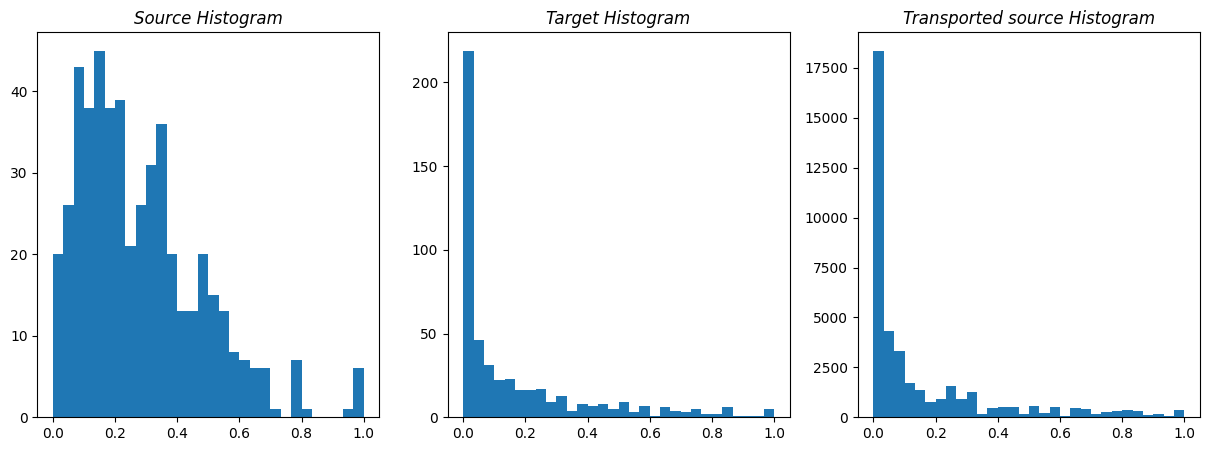

In [6]:
rng = np.random.RandomState(42)
new_hic, orig_hic, Xs, Xt = generate_hic(rng, synthetic_biological_structure, trussart_hic, use_ice =True, use_minmax =True, use_ot = True, use_softmax =False, seed =42, plot_optimal_transport =True, exponent =1)

plot_optimal_transport(Xs, Xt, new_hic)

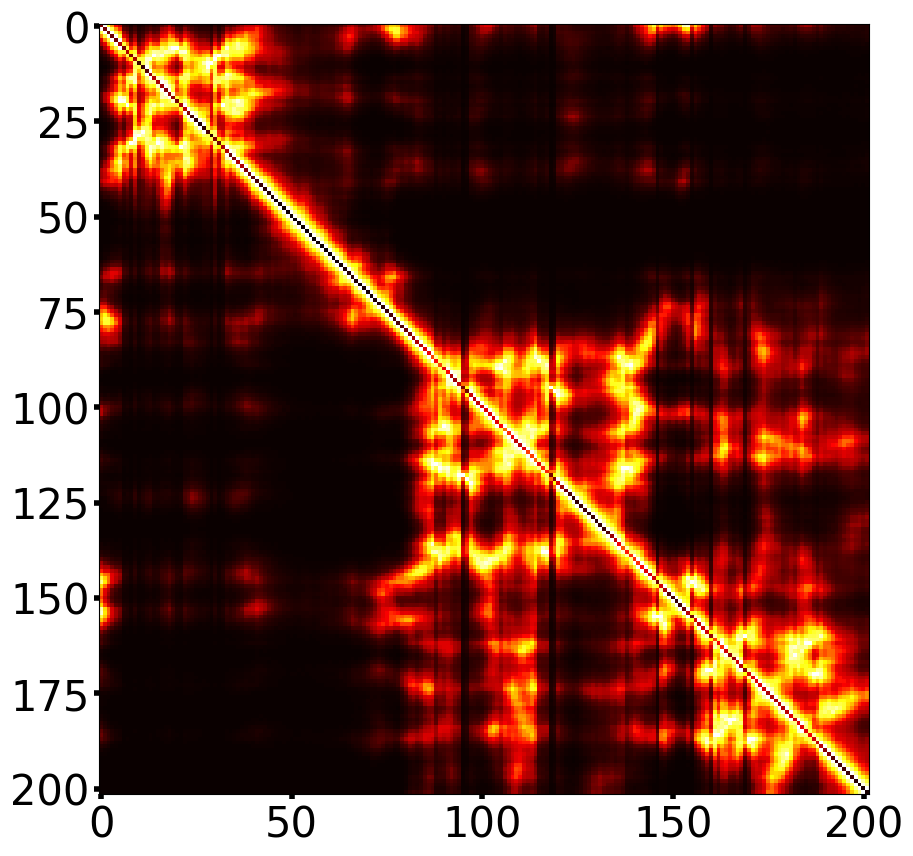

In [7]:
plot_hic(new_hic)

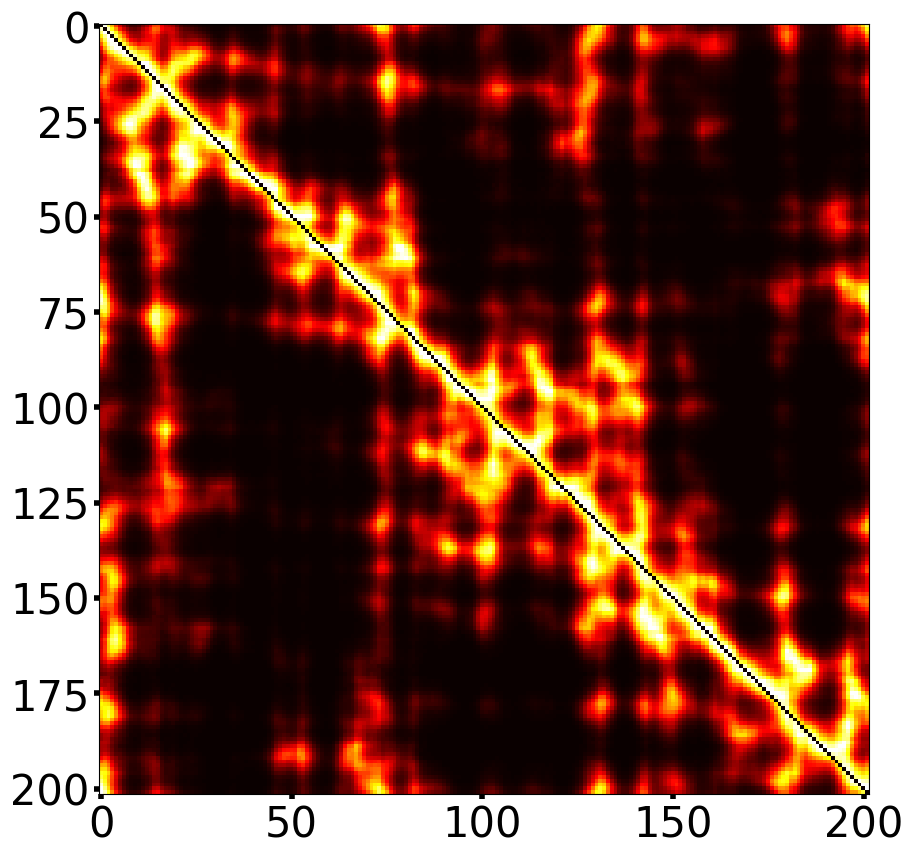

In [8]:
plot_hic(trussart_hic)

Generate the data

The following section uses the desired parameters to output NB_TRAINING training data and NB_testing testing data. 

In [9]:
rng = np.random.RandomState(SEED)
random.seed(SEED)
np.random.seed(SEED)
synthetic_biological_uniform_data_generator(rng, trussart_hic, n_structure = NB_TRAINING, data_path =  DATA_PATH,  nb_bins = NB_BINS, delta = DELTA, st_sig = ST_SIG, end_sig = END_SIG, sig = SIG, clust_sig = CLUST_SIG, clust_prob = CLUST_PROB, secondstep = SECONDSTEP, seed = SEED, alpha = EXPONENT, is_training = True , icing = ICING, minmaxuse= MINMAXUSE, transportation = TRANSPORTATION, softmaxing = SOFTMAXING)


100%|██████████| 200/200 [06:27<00:00,  1.94s/it]


In [10]:
rng = np.random.RandomState(SEED)
random.seed(SEED)
np.random.seed(SEED)
synthetic_biological_uniform_data_generator(rng, trussart_hic, n_structure = NB_testing, data_path =  DATA_PATH,  nb_bins = NB_BINS, delta = DELTA, st_sig = ST_SIG, end_sig = END_SIG, sig = SIG, clust_sig = CLUST_SIG, clust_prob = CLUST_PROB, secondstep = SECONDSTEP, seed = SEED, alpha = EXPONENT, is_training = False , icing = ICING, minmaxuse= MINMAXUSE, transportation = TRANSPORTATION, softmaxing = SOFTMAXING)

100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


## Model Training and Calibration

In [11]:
SEED = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

The synthetic train and test distance structure and HiC matrices are first retrieved from the required data folder 

In [26]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


Data is then loaded 

In [27]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

100%|██████████| 200/200 [00:00<00:00, 33399.46it/s]

Processing...


Done!
200


In [28]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.2)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)
print(test_size)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

100%|██████████| 100/100 [00:00<00:00, 24967.58it/s]

Processing...
Done!
100


In [29]:
print(len(test_test_calib_loader))

2


The device on which to run the model is first selected, then the model is declared with the following parameters: NB_BINS is the number of loci in the structure, ANGLE_PRED is the same as the EMBEDDING_SIZE representing the 3d dimension embedding, NUM_BINS_LOGITS represents the number of confidence classes, ZERO_INIT decides whether to use a zero initialisation of the confidence learning weights or a Xavier initialisation, NB_HEAD is the number of heads in the encoder transformer layer, NB_HIDDEN is the first d projection dimension parameter as well as the number of feedforward passes in the first encoder layer, DROPOUT is the dropout rate of the transformer model, SECD_HID is the number of feedforward passes in the second encoder transformer layer. Then the optimizer is set to run on the model's parameters. 

In [30]:
distance_loss_fct = torch.nn.MSELoss()

In [31]:
device = torch.device('cpu')
model = TransConf(NB_BINS, ANGLE_PRED, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT, NB_HEAD, NB_HIDDEN, NB_LAYERS, DROPOUT, SECD_HID).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

The following first trains the model with LAMBDA_KABSCH and LAMBDA_BIO being the weights of the kabsch and biological losses. LAMBDA_LDDT is the weight of the confidence loss. Then the model is evaluated with validation, testing and training results per epoch being stored in an array and being printed for the user to see. 

In [32]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_trans_conf(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_trans_conf(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_trans_conf(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)

    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)

    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0194, Tr K: 0.1923, Tr D: 0.0905, Te B: 0.0190, Te K: 0.1938, Te D: 0.0908, Tr LD: 0.4317, Te LD: 0.4291, Trus: 0.1449
E: 002, Tr B: 0.0186, Tr K: 0.1732, Tr D: 0.0729, Te B: 0.0186, Te K: 0.1768, Te D: 0.0740, Tr LD: 0.3978, Te LD: 0.3971, Trus: 0.1453
E: 003, Tr B: 0.0185, Tr K: 0.1554, Tr D: 0.0649, Te B: 0.0189, Te K: 0.1579, Te D: 0.0655, Tr LD: 0.3660, Te LD: 0.3663, Trus: 0.1447
E: 004, Tr B: 0.0185, Tr K: 0.1496, Tr D: 0.0597, Te B: 0.0192, Te K: 0.1517, Te D: 0.0599, Tr LD: 0.3591, Te LD: 0.3592, Trus: 0.1505
E: 005, Tr B: 0.0182, Tr K: 0.1448, Tr D: 0.0537, Te B: 0.0192, Te K: 0.1458, Te D: 0.0538, Tr LD: 0.3607, Te LD: 0.3589, Trus: 0.1561
E: 006, Tr B: 0.0175, Tr K: 0.1435, Tr D: 0.0496, Te B: 0.0189, Te K: 0.1447, Te D: 0.0503, Tr LD: 0.3610, Te LD: 0.3612, Trus: 0.1555
E: 007, Tr B: 0.0173, Tr K: 0.1374, Tr D: 0.0443, Te B: 0.0176, Te K: 0.1381, Te D: 0.0452, Tr LD: 0.3591, Te LD: 0.3606, Trus: 0.1501
E: 008, Tr B: 0.0174, Tr K: 0.1290, Tr D: 0.0400, Te B:

The Following takes one of the best synthetically predicted structure and plots it along with the true synthetic structure

In [33]:
kabsch_distances = []

for graph_index in range(test_size):

    test_true_structure = test_true_structures[graph_index,:,:]
    test_pred_structure = test_pred_structures[graph_index,:,:]
    
    d = kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
    kabsch_distances.append(d)
sorted_kabsch = np.argsort(kabsch_distances)
GRAPH_TESTED = sorted_kabsch[2]

In [34]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)/3))



Kabsch distance is 0.009710277545857333


<Figure size 50000x50000 with 0 Axes>

Make a gif of the structure in time

In [35]:
make_gif("", "gifs/trussart_linear.gif")

Ground truth consensus Trussart structure plotted against the predicted one

In [36]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, trussart_pred_distance, trussart_pred_logits = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.051457568277809874


<Figure size 50000x50000 with 0 Axes>

predicted and true lddt prediction confidence of the trussart structure

In [37]:
confidence_metrics, pLLDTs = get_confidence_metrics(trussart_pred_logits.detach().numpy()[0])
print(confidence_metrics)

value = lddt(torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0),torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0), per_residue=True)
print(torch.mean(value))

81.19782492511776
tensor(0.8339, dtype=torch.float64)


Temperature Scaling with predicted scaled confidences and the Mean Squared error of calibrated and uncalibrated confidences

In [38]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)
confidence_metric_scaled, plddt_scaled = scale_logits(trussart_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, plddt_scaled)
print(mse_unscalled)
print(mse_scalled)

8
Before temperature - NLL: 0.041
tensor(0.8146, grad_fn=<MulBackward0>)
tensor(0.8144, grad_fn=<MulBackward0>)
tensor(0.8141, grad_fn=<MulBackward0>)
tensor(0.8139, grad_fn=<MulBackward0>)
tensor(0.8137, grad_fn=<MulBackward0>)
tensor(0.8134, grad_fn=<MulBackward0>)
tensor(0.8132, grad_fn=<MulBackward0>)
tensor(0.8130, grad_fn=<MulBackward0>)
tensor(0.8128, grad_fn=<MulBackward0>)
tensor(0.8125, grad_fn=<MulBackward0>)
tensor(0.8123, grad_fn=<MulBackward0>)
tensor(0.8121, grad_fn=<MulBackward0>)
tensor(0.8119, grad_fn=<MulBackward0>)
tensor(0.8118, grad_fn=<MulBackward0>)
tensor(0.8116, grad_fn=<MulBackward0>)
tensor(0.8114, grad_fn=<MulBackward0>)
tensor(0.8112, grad_fn=<MulBackward0>)
tensor(0.8111, grad_fn=<MulBackward0>)
tensor(0.8109, grad_fn=<MulBackward0>)
tensor(0.8108, grad_fn=<MulBackward0>)
tensor(0.8106, grad_fn=<MulBackward0>)
tensor(0.8105, grad_fn=<MulBackward0>)
tensor(0.8103, grad_fn=<MulBackward0>)
tensor(0.8102, grad_fn=<MulBackward0>)
tensor(0.8101, grad_fn=<MulBac

Isotonic Regression Calibration with predicted scaled confidences and the Mean Squared error of calibrated and uncalibrated confidences

In [39]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_iso)
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_iso)
print(mse_unscalled)
print(mse_scalled)

3.1040441725808794
3.1128204306310945
82.10458566236
18.97731231644556
14.734409527339109


Beta Calibration with predicted scaled confidences and the Mean Squared error of calibrated and uncalibrated confidences

In [40]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_beta)
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_beta)
print(mse_unscalled)
print(mse_scalled)

3.1040441725808794
3.0395026869407973
81.97523187349502
18.97731231644556
15.371909924157878
